# AI305-Lab3 -Fall 22

## Basic Regression Tree
#### Implementation of a regression tree, step by step



First, we import various
packages and define a function to generate the training and test data.

In [2]:
import numpy as np
from sklearn.datasets import make_friedman1
from sklearn.model_selection import train_test_split

make_friedman1()

Generate the “Friedman #1” regression problem.
This dataset is described in Friedman [1] and Breiman [2].
Inputs X are independent features uniformly distributed on the interval [0, 1]. The output y is created according to the formula:
y(X) = 10 * sin(pi * X[:, 0] * X[:, 1]) + 20 * (X[:, 2] - 0.5) ** 2 + 10 * X[:, 3] + 5 * X[:, 4] + noise * N(0, 1).
Out of the n_features features, only 5 are actually used to compute y. The remaining features are independent of y.

In [3]:
def makedata():
  n_points = 500 # points

  X, y =  make_friedman1(n_samples=n_points, n_features=5,
                         noise=1.0, random_state=100)

  return train_test_split(X, y, test_size=0.5, random_state=3)


The “main” method calls the makedata method, uses the training data to build a regression tree, and then predicts the responses of the test set and reports the mean squared-error loss.

In [4]:

def main():
  X_train, X_test, y_train, y_test = makedata()
  maxdepth = 10 # maximum tree depth
  # Create tree root at depth 0
  treeRoot = TNode(0, X_train,y_train)

  # Build the regression tree with maximal depth equal to max_depth
  Construct_Subtree(treeRoot, maxdepth)

  # Predict
  y_hat = np.zeros(len(X_test))
  for i in range(len(X_test)):
     y_hat[i] = Predict(X_test[i],treeRoot)

  MSE = np.mean(np.power(y_hat - y_test,2))
  print("Basic tree: tree loss = ",  MSE)


The next step is to specify a tree node as a Python class. Each node has a number of attributes, including the features and the response data (X and y) and the depth at which the node is placed in the tree. The root node has depth 0. Each node w can calculate its contribution to the squared-error training loss

![image.png](attachment:image.png)


Note that we have omitted the constant 1/n term when training the tree, which simply scales the loss
![image.png](attachment:image.png)

In [5]:
# tree node
class TNode:
   def __init__(self, depth, X, y):
      self.depth = depth
      self.X = X   # matrix of explanatory variables
      self.y = y   # vector of response variables
      # initialize optimal split parameters
      self.j = None
      self.xi = None
      # initialize children to be None
      self.left = None
      self.right = None
      # initialize the regional predictor
      self.g = None

   def CalculateLoss(self):
       if(len(self.y)==0):
           return 0

       return np.sum(np.power(self.y- self.y.mean(),2))



The function below implements the training (tree-building) Algorithm
![image.png](attachment:image.png)

In [6]:
def Construct_Subtree(node, max_depth):
    if(node.depth == max_depth or len(node.y) == 1):
        node.g  = node.y.mean()
    else:
        j, xi = CalculateOptimalSplit(node)
        node.j = j
        node.xi = xi
        Xt, yt, Xf, yf = DataSplit(node.X, node.y, j, xi)

        if(len(yt)>0):
            node.left = TNode(node.depth+1,Xt,yt)
            Construct_Subtree(node.left, max_depth)

        if(len(yf)>0):
            node.right = TNode(node.depth+1, Xf,yf)
            Construct_Subtree(node.right, max_depth)

    return node

This requires an implementation of the CalculateOptimalSplit function. To start,
we implement a function DataSplit that splits the data according to ![image.png](attachment:image.png)

In [7]:
# split the data-set
def DataSplit(X,y,j,xi):
    ids = X[:,j]<=xi
    Xt  = X[ids == True,:]
    Xf  = X[ids == False,:]
    yt  = y[ids == True]
    yf  = y[ids == False]
    return Xt, yt, Xf, yf

The CalculateOptimalSplit method runs through the possible splitting thresholds from the set {xj,k} and finds the optimal split.

In [8]:
def CalculateOptimalSplit(node):
    X = node.X
    y = node.y
    best_var = 0
    best_xi = X[0,best_var]
    best_split_val = node.CalculateLoss()

    m, n  = X.shape
    # pass through the predictors and the values
    for j in range(0,n):
        for i in range(0,m):
            xi = X[i,j]
            Xt, yt, Xf, yf = DataSplit(X,y,j,xi)
            tmpt = TNode(0, Xt, yt)
            tmpf = TNode(0, Xf, yf)
            loss_t = tmpt.CalculateLoss()
            loss_f = tmpf.CalculateLoss()
            curr_val =  loss_t + loss_f
            if (curr_val < best_split_val):
                best_split_val = curr_val
                best_var = j
                best_xi = xi
    return best_var,  best_xi

Finally, we implement the recursive method for prediction.

In [9]:
def Predict(X,node):
    if(node.right == None and node.left != None):
        return Predict(X,node.left)

    if(node.right != None and node.left == None):
        return Predict(X,node.right)

    if(node.right == None and node.left == None):
        return node.g
    else:
        if(X[node.j] <= node.xi):
            return Predict(X,node.left)
        else:
            return Predict(X,node.right)


Running the main function defined above gives a similar result to what one would achieve with the sklearn package, using the DecisionTreeRegressor method.

In [10]:

main()  # run the main program

Basic tree: tree loss =  9.067077996170276


In [11]:
# compare with sklearn
from sklearn.tree import DecisionTreeRegressor
X_train, X_test, y_train, y_test = makedata()
regTree = DecisionTreeRegressor(max_depth = 10, random_state=0)
regTree.fit(X_train,y_train)
y_hat = regTree.predict(X_test)
MSE2 = np.mean(np.power(y_hat - y_test,2))
print("DecisionTreeRegressor: tree loss = ",  MSE2)


DecisionTreeRegressor: tree loss =  10.197991295531748


Plot the DT:

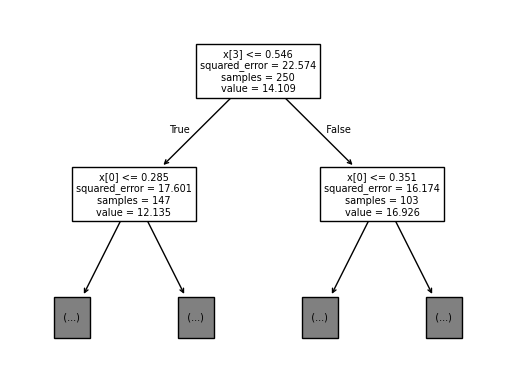

In [12]:
from sklearn import tree
import matplotlib.pyplot as plt
tree.plot_tree(regTree,max_depth=1)
plt.show()

### Activity
#### 1- Modify the previous code to implement classification decision tree
#### 2- implement one of the ensemble methods covered in the lecture: Bagging, random forest, or boosting


# **1)**

In [14]:
import numpy as np
from sklearn.datasets import make_friedman1
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor
from sklearn import tree
import matplotlib.pyplot as plt
from sklearn.datasets import make_classification

In [15]:
def makedata():
  n_points = 500 # points

  X, y =  make_classification(n_samples=n_points, n_features=5,
                         n_informative=2, n_redundant=0,
                         random_state=100)

  return train_test_split(X, y, test_size=0.5, random_state=3)

In [16]:
def main():
  X_train, X_test, y_train, y_test = makedata()
  maxdepth = 10 # maximum tree depth
  # Create tree root at depth 0
  treeRoot = TNode(0, X_train,y_train)

  # Build the regression tree with maximal depth equal to max_depth
  Construct_Subtree(treeRoot, maxdepth)

  # Predict
  y_hat = np.zeros(len(X_test))
  for i in range(len(X_test)):
     y_hat[i] = Predict(X_test[i],treeRoot)

  Accuracy = np.mean(y_hat == y_test)
  print("Basic tree: tree Accuracy = ",  Accuracy)

In [17]:
# tree node
class TNode:
   def __init__(self, depth, X, y):
      self.depth = depth
      self.X = X   # matrix of explanatory variables
      self.y = y   # vector of response variables
      # initialize optimal split parameters
      self.j = None
      self.xi = None
      # initialize children to be None
      self.left = None
      self.right = None
      # initialize the regional predictor
      self.g = None

   def CalculateLoss(self):
       if(len(self.y)==0):
           return 0

       return np.sum(np.power(self.y- np.argmax(np.bincount(self.y)),2))

In [18]:
def Construct_Subtree(node, max_depth):
    if(node.depth == max_depth or len(node.y) == 1):
        node.g  = np.argmax(np.bincount(node.y))
    else:
        j, xi = CalculateOptimalSplit(node)
        node.j = j
        node.xi = xi
        Xt, yt, Xf, yf = DataSplit(node.X, node.y, j, xi)

        if(len(yt)>0):
            node.left = TNode(node.depth+1,Xt,yt)
            Construct_Subtree(node.left, max_depth)

        if(len(yf)>0):
            node.right = TNode(node.depth+1, Xf,yf)
            Construct_Subtree(node.right, max_depth)

    return node

In [19]:
# split the data-set
def DataSplit(X,y,j,xi):
    ids = X[:,j]<=xi
    Xt  = X[ids == True,:]
    Xf  = X[ids == False,:]
    yt  = y[ids == True]
    yf  = y[ids == False]
    return Xt, yt, Xf, yf

In [20]:
def CalculateOptimalSplit(node):
    X = node.X
    y = node.y
    best_var = 0
    best_xi = X[0,best_var]
    best_split_val = node.CalculateLoss()

    m, n  = X.shape
    # pass through the predictors and the values
    for j in range(0,n):
        for i in range(0,m):
            xi = X[i,j]
            Xt, yt, Xf, yf = DataSplit(X,y,j,xi)
            tmpt = TNode(0, Xt, yt)
            tmpf = TNode(0, Xf, yf)
            loss_t = tmpt.CalculateLoss()
            loss_f = tmpf.CalculateLoss()
            curr_val =  loss_t + loss_f
            if (curr_val < best_split_val):
                best_split_val = curr_val
                best_var = j
                best_xi = xi
    return best_var,  best_xi

In [21]:
def Predict(X,node):
    if(node.right == None and node.left != None):
        return Predict(X,node.left)

    if(node.right != None and node.left == None):
        return Predict(X,node.right)

    if(node.right == None and node.left == None):
        return node.g
    else:
        if(X[node.j] <= node.xi):
            return Predict(X,node.left)
        else:
            return Predict(X,node.right)

main()

Basic tree: tree Accuracy =  0.912


# **2) Boosting**

In [ ]:
from sklearn.ensemble import AdaBoostClassifier


def makedata():
  n_points = 500  # points

  X, y = make_classification(n_samples=n_points, n_features=5,
                             n_informative=2, n_redundant=0,
                             random_state=100)

  return train_test_split(X, y, test_size=0.5, random_state=3)


def main():
  X_train, X_test, y_train, y_test = makedata()
  clf = AdaBoostClassifier(n_estimators=100, random_state=0)

  clf.fit(X_train, y_train)

  y_pred = clf.predict(X_test)

  accuracy = np.mean(y_pred == y_test)
  print("Boosting (AdaBoost): Accuracy =", accuracy)


main()